# Import Necessary Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Transformer, Geod
from shapely.geometry import Point, LineString, Polygon

# Data Loading
I came across consistent errors with loading the JSON files 'datasourceerror: failed to read esrijson data' and therefore decided to download the ARCGIS data (“Wildland Fire Polygons Fire Feature Data ArcGIS Pro 2.8 Geodatabase”) and load it using GeoPandas. 

Additionally, vector math is extremely easy out of the box using GeoPandas, so for the scope of this assignment, I will be using GeoPandas instead of GeoJSON

In [3]:
# The GeoDataBase format can be read using the geopandas read_file method
gdf = gpd.read_file('../data/Fire_Feature_Data.gdb/')
gdf.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Big Quilcene River (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"MULTIPOLYGON (((-1883775.596 1194154.192, -188..."
1,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Harrison Lake (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"MULTIPOLYGON (((-1887470.131 1187759.244, -188..."
2,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Tunnel Creek (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"MULTIPOLYGON (((-1889386.119 1190683.928, -188..."
3,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",1870 (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"MULTIPOLYGON (((-1428896.297 864980.034, -1428..."
4,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",No Fire Name Provided (2),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"MULTIPOLYGON (((-1371410.414 595942.396, -1371..."


In [4]:
# We see there are 135K instances of fire in the dataset, this number should go down as we filter the data
gdf.shape

(135061, 30)

### Subset the data according to the analysis requirements

In [5]:
# Subset for year
gdf = gdf[gdf.Fire_Year > 1963]

### Analyze GIS data

It is important to check the CRS of the data to ensure that the unit for distances we aim to measure are inline with the data

In [6]:
gdf.crs

<Projected CRS: ESRI:102008>
Name: North_America_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

This CRS uses meters as it's unit of distance which is great. However, this project does not guarantee preservation of distances. 
Let's change the projection to one that preserves distances

In [7]:
# Change CRS to one that preserves distances
gdf = gdf.to_crs('ESRI:102005')

The following coordinate data has been taken from the [Yavapai County]((https://en.wikipedia.org/wiki/Yavapai_County,_Arizona)) page on Wikipedia

In [8]:
# Encode target country coodinates in NAD-83 style
# This is my county!
county_location = { 'yavapai': {'county': 'Yavapai Country', 'latlon' : [-112.54, 34.561389]}}

county_location_point = Point(county_location['yavapai']['latlon'])
county_location_point = gpd.GeoDataFrame({'geometry': [county_location_point]}, crs='4326')
county_location_point = county_location_point.to_crs(gdf.crs)

> Note: This part is particularly tricky. We set the CRS to 4326 when we define the point since we are using GPS coordinates, but change the CRS to match the fire data right after

In [9]:
county_location_point

,geometry
0,POINT (-1506022.835 -355637.409)


> We can see how the coordinates changed from -112.54, 34.561389

Once we have the coordinates of our county instantiated, we need to draw a 1250 mile radius around it to check which fires are relevant. We use the simple and out of the box buffer functionality of GeoPandas

In [10]:
buffer_length_in_meters = (1250 * 1609.34) # Miles to Meters conversion
county_location_buffer = county_location_point.buffer(buffer_length_in_meters)
county_location_buffer = gpd.GeoDataFrame(county_location_buffer).set_geometry(0)

Multipolygons can be pretty confusing. Looking at the dataframe and its values is practically useless, so let's visualise things to verify our approach.

<Axes: >

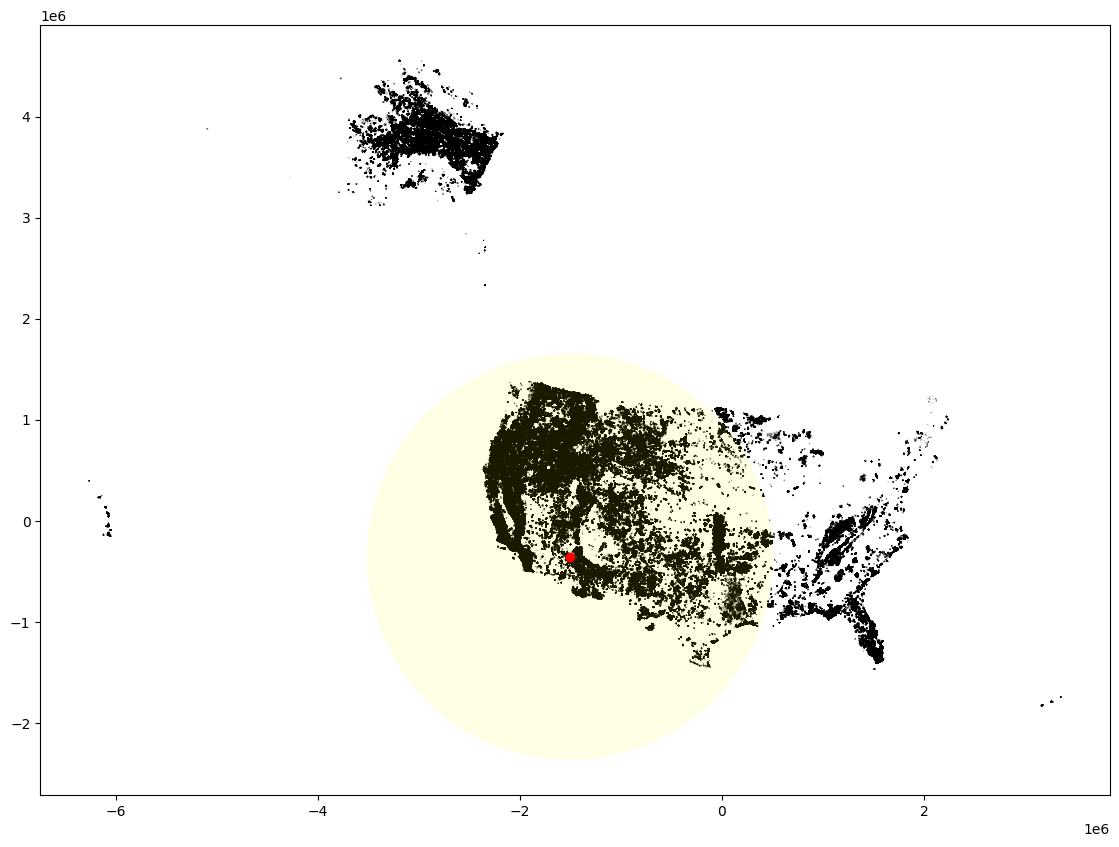

In [11]:
# TODO: Label plot
ax = gdf.plot(figsize=(16, 10), color='white', edgecolor='black')
county_location_buffer.plot(ax=ax, color='yellow', alpha=0.1)
county_location_point.plot(ax=ax, color='red', alpha=1)

We can see that the location of our country looks correct, and is at the centre of the cirle that encompasses 1250 miles.

Now let's find the intersection between the data for all us the US and our 1250 mile radius

### Subset by distance

In [12]:
# Let's ensure that we are in the same CRS
assert gdf.crs == county_location_buffer.crs

In [13]:
# Now we select the overlapping data to subset to a 1250 mile radius
gdf_subset = gpd.sjoin(gdf, county_location_buffer)

In [14]:
# Apply transformation to get distanct in miles
gdf_subset['Distance_To_County_miles'] = gdf_subset.geometry.apply(lambda x: x.distance(county_location_point).geometry*0.000621371)

### Smoke Impact Estimation
Let's identify some columns that we assume would impact the smoke levels in our city

In [15]:
# Select a subset of columns that might be of interest
columns_of_interest = ['USGS_Assigned_ID', 
                       'Assigned_Fire_Type', 
                       'Fire_Year', 
                       'GIS_Acres',
                       'Distance_To_County_miles']

In [16]:
# Extract subset columns
df = gdf_subset[columns_of_interest]
df.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Distance_To_County_miles
14599,14600,Wildfire,1964,65338.877636,394.787966
14600,14601,Wildfire,1964,55960.694158,615.719786
14601,14602,Wildfire,1964,19218.105903,273.839838
14602,14603,Wildfire,1964,18712.494746,701.033798
14603,14604,Wildfire,1964,16887.001024,747.486548


Since this is an estimation exercise without a target label in mind, we are to assume how these features would impact the smoke levels. Going by gut feeling, this is my estimator:

    smoke_impact = 0.35*GIS_Acres + 0.55*1/Distance_To_County_miles + 0.10[Assigned_Fire_Type == 'Wildfire'] +  0.05[Assigned_Fire_Type == 'Prescribed Fire'] - 0.2

    smoke_impact = 1/(1+e^(-smoke_impact))

Since Assigned_Fire_Type is a categorical variable, we must break it down into multiple binary variables, which are true when Assigned_Fire_Type belongs to their category. 

The idea behind this rough estimate is simple: 
- The bigger the fire, the larger the impact
- The closer the fire, the larger the impact
- Wildfires will probably have more impact than a Prescribed Fire

I have additionally take a -0.2 bias term since our data only contributes to shifting the impact upwards. We will use a function that will keep the impact range between 0,1 so it's probably nice to have a term which brings the impact low. In any case, we won't see a fire have a negative impact on our estimate 

In [17]:
# Normalise the data
numerical_variables = ['GIS_Acres', 'Distance_To_County_miles']
df_normalized = (df[numerical_variables]-df[numerical_variables].min())/(df[numerical_variables].max()-df[numerical_variables].min())
df = df.join(df_normalized, rsuffix='_normalised')

In [18]:
# This is our estimator function. It follows the earlier prescribed formula
def estimator(df):
    value = 0.1*df['GIS_Acres'] + \
            1/(df['Distance_To_County_miles']**2) + \
            0.10*(df.Assigned_Fire_Type == 'Wildfire') + \
            0.05*(df.Assigned_Fire_Type == 'Prescribed Fire') - 0.2
    value = 1/(1+np.exp(-value))
    return value

In [19]:
# Apply the estimator to get impact estiamte values
df['impact_estimate'] = estimator(df)

The final smoke estimate should be the sum of the smoke estimate of individual. We need to accumulate the effect of each fire during the fire season. Therefore, all the downstream processes for visualisation will utilise the groupby('Fire_Year').sum() function. 

In [20]:
# Sort the dataframe by the year
df = df.sort_values(by='Fire_Year')

<Axes: xlabel='Fire_Year'>

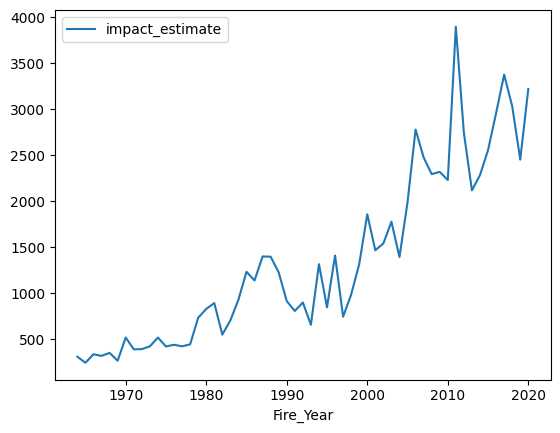

In [21]:
# Plot the data and groupby Year
df[['Fire_Year', 'impact_estimate']].groupby('Fire_Year').sum().reset_index().plot(x='Fire_Year', y='impact_estimate')

### Forecast
Since are forecasting our own estimate, it makes sense to use an AutoRegressive model. An autoregressive model is a time series model where future values of a variable are linearly dependent on its past values. 

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that combines autoregressive and moving average components, incorporating differencing to achieve stationarity. It enablues us predict the future values based on historical data patterns using a single variable onto itself.

In [22]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Set train size to 80%
train_size = int(0.8 * len(df))
# Group by and sum since we are aggregating fires all over the year.
train_data = df.groupby('Fire_Year').sum()['impact_estimate'][:train_size]
test_data = df.groupby('Fire_Year').sum()['impact_estimate'][train_size:]

# Define the order of the ARIMA model (p, d, q)
d = 2  # Integration order (to make the time series stationary)
p = 3  # Autoregressive order
q = 3  # Moving average order

# Fit the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Make predictions for the next 28 time steps (2020 onwards, 25 years ahead of 2023)
forecast_values = model_fit.forecast(steps=28)
forecast_values

/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/sta

57    2910.839350
58    2957.929363
59    3240.479706
60    3051.585620
61    3161.467479
62    3354.163590
63    3176.724907
64    3368.978293
65    3446.795048
66    3336.153412
67    3548.883132
68    3544.346807
69    3513.000027
70    3704.268359
71    3655.452008
72    3695.412256
73    3841.124225
74    3783.625540
75    3873.881535
76    3967.659630
77    3927.482953
78    4042.843466
79    4091.677242
80    4082.673057
81    4200.596612
82    4219.014115
83    4243.777943
84    4348.429853
Name: predicted_mean, dtype: float64

In [23]:
# Let's look at the 95% confidence interval
conf_interval = model_fit.get_forecast(steps=28).conf_int(0.05)
conf_interval

/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,lower impact_estimate,upper impact_estimate
57,2026.236656,3795.442044
58,1854.164035,4061.694691
59,1958.650931,4522.308481
60,1590.511691,4512.659548
61,1508.074189,4814.860768
62,1578.695524,5129.631656
63,1234.415926,5119.033888
64,1281.797992,5456.158594
65,1242.530632,5651.059463
66,980.361118,5691.945706


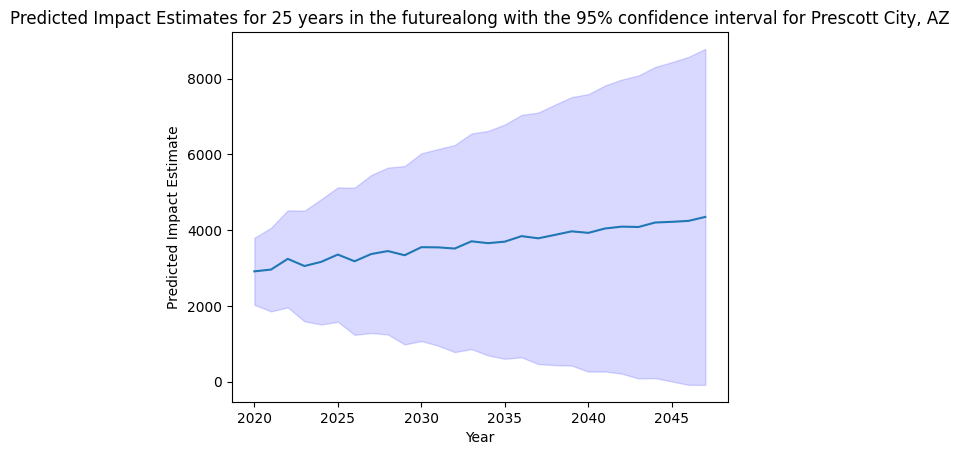

In [24]:
import matplotlib.pyplot as plt

# Plot the data
plt.plot(range(2020, 2048), forecast_values)
# Plot the confidence interval
plt.fill_between(range(2020, 2048), conf_interval['lower impact_estimate'], 
                 conf_interval['upper impact_estimate'], 
                 color='b', 
                 alpha=.15)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Predicted Impact Estimate')
plt.title("Predicted Impact Estimates for 25 years in the futurealong with the 95% confidence interval for Prescott City, AZ")

# Save figure
plt.savefig('../Results/predict_impact.png')

We can see that the model is not very confident, and the confidence interval grows as we try to predict values well into the future

## Visualisation

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size for all seaborn figures
sns.set(rc={'figure.figsize':(12,8)})

In [26]:
# Read the AQI Data
df_aqi = pd.read_csv('../Results/yearly_aqi_data.csv')

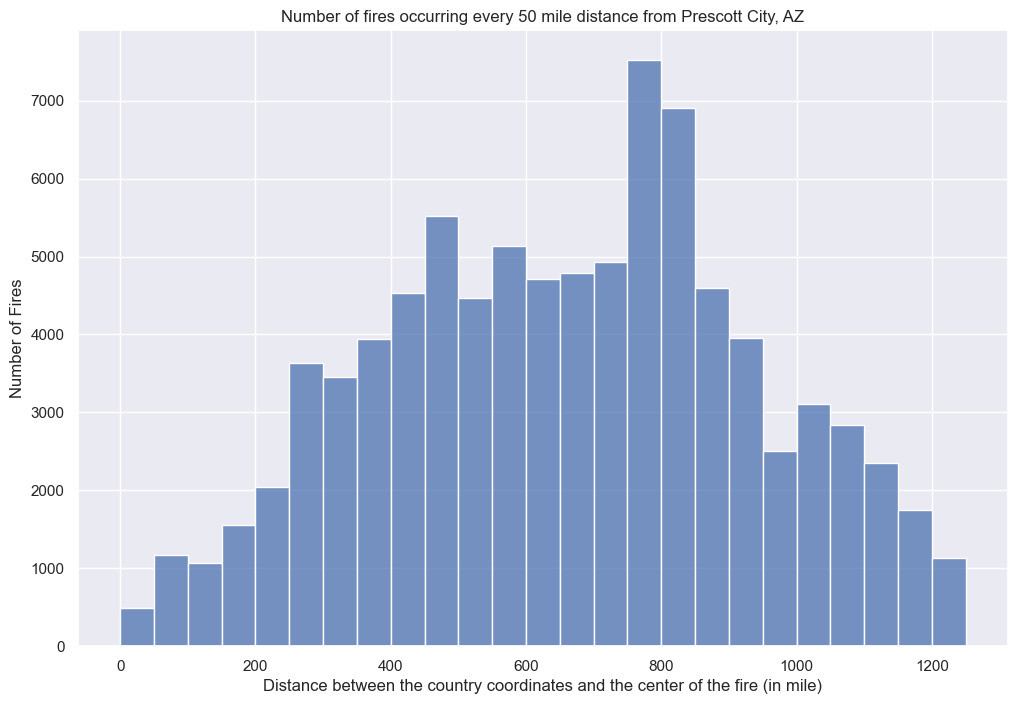

In [27]:
# Plot the data
fig = plt.figure()
ax = sns.histplot(df, x='Distance_To_County_miles', binrange=(0, 1250), binwidth=50)

# Add title, grid and lables
ax.set_title("Number of fires occurring every 50 mile distance from Prescott City, AZ")
ax.set(xlabel='Distance between the country coordinates and the center of the fire (in mile)', ylabel='Number of Fires')

# Save figure
fig.savefig('../Results/histogram_fires.png')
print('')

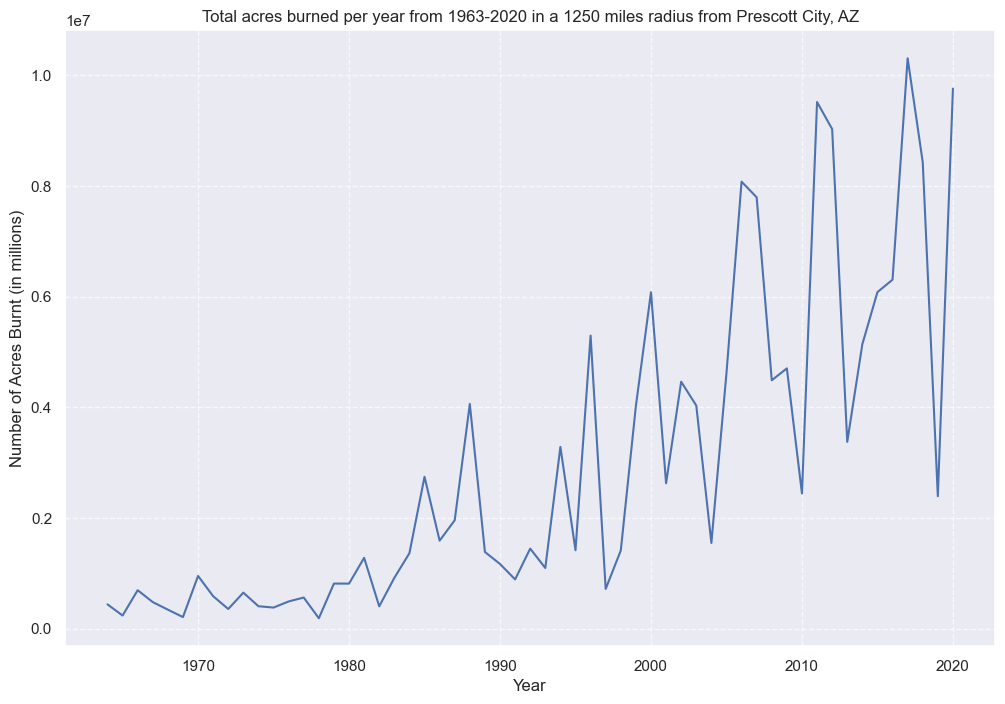

In [28]:
# Plot the data
fig = plt.figure()
ax = df.groupby('Fire_Year').GIS_Acres.sum().plot(figsize=(12,8))

# Add title, grid and lables
ax.set_title("Total acres burned per year from 1963-2020 in a 1250 miles radius from Prescott City, AZ")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Acres Burnt (in millions)")
ax.grid(True, linestyle='--', alpha=0.7)

# Save the figure
fig.savefig('../Results/acres_burnt.png')

We notice that the peak of every few years keep on increasing. There are some years where the number of acres burned drops but overall the trend is quite apparent

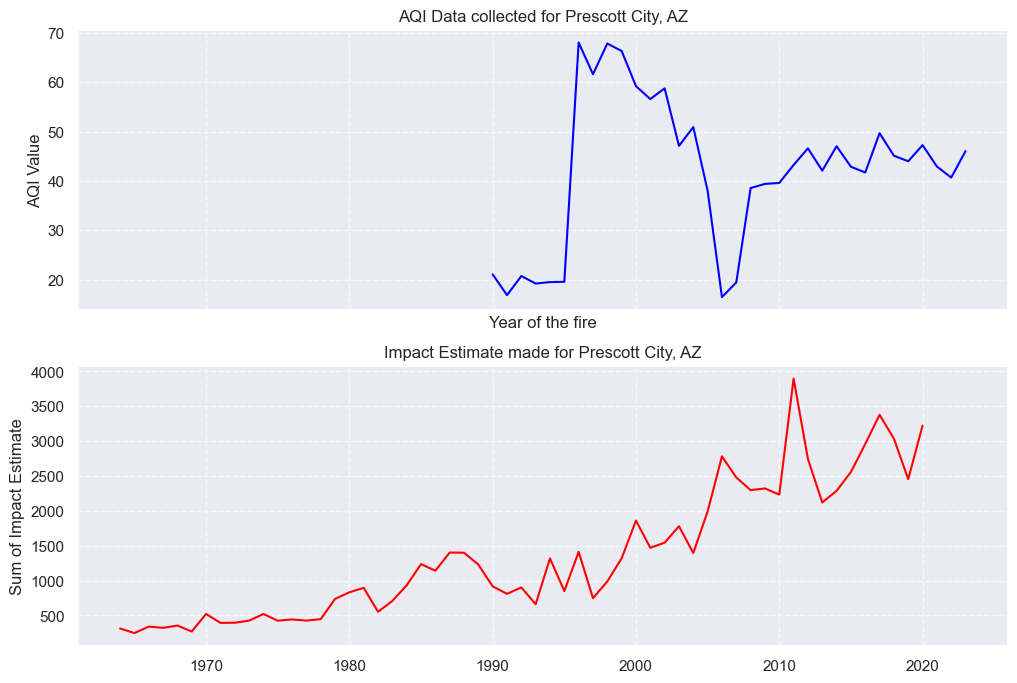

In [29]:
import matplotlib.pyplot as plt
# Create the first plot
# fig, ax1 = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot the first dataframe on the first y-axis
# Whenever using the AQI, we will take the mean AQI for the year
ax1.plot(df_aqi[['AQI', 'date_year']].groupby('date_year').mean(), color='blue', label='AQI Values')
ax1.set_xlabel('Year of the fire')
ax1.set_ylabel('AQI Value')


# Plot the second dataframe on the second y-axis
ax2.plot(df[['Fire_Year', 'impact_estimate']].groupby('Fire_Year').sum(), color='red', label='Impact Estimate')
ax2.set_ylabel('Sum of Impact Estimate')

# Set title and stylistic attributes
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)

ax1.set_title("AQI Data collected for Prescott City, AZ")
ax2.set_title("Impact Estimate made for Prescott City, AZ")

# Display the plot
plt.show()
fig.savefig('../Results/AQIvsEstimate.png')

Unfortunately, the AQI data is very sparse, and only available from 1990. We must take this data with a grain of salt and not consider it the ground truth right away. Only a few days of data is used to aggregate for one fire season and there is a lot of scope for improvement. While our wildfire estimate does not seems to be similar to the AQI, only an indepth correlation analysis would yeild statistically significant results. 

In [31]:
# Have a look at the dataframe
df.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Distance_To_County_miles,GIS_Acres_normalised,Distance_To_County_miles_normalised,impact_estimate
14599,14600,Wildfire,1964,65338.877636,394.787966,4.171614e-02,0.315937,1.000000
14846,14847,Wildfire,1964,0.131077,357.517500,8.368597e-08,0.286110,0.478293
14845,14846,Wildfire,1964,0.131077,356.387820,8.368624e-08,0.285206,0.478293
14844,14845,Wildfire,1964,0.131079,355.672149,8.368759e-08,0.284633,0.478293
14843,14844,Wildfire,1964,0.131084,359.370832,8.369091e-08,0.287593,0.478293
